In [1]:
# Import packages
import pandas as pd
import numpy as np
import warnings
import socceraction.spadl as spadl
import numpy as np
import os
import matplotsoccer
import matplotlib.pyplot as plt
import joblib

from datetime import datetime
from src.data_processing import config_h5_file_paths, load_match_data
from src.vaep_processing import load_vaep, compare_vaep_on_actions

In [2]:
# Ignore warnings
warnings.filterwarnings(
  action="ignore", 
  message="credentials were not supplied. open data access only"
)
warnings.simplefilter(
  action='ignore', 
  category=pd.errors.PerformanceWarning
)
pd.set_option('future.no_silent_downcasting', True)

warnings.filterwarnings(
    "ignore",
    message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method."
)

Modelle laden

In [3]:
# Pfad zum Models-Ordner
models_dir = "Models"

# Modelle laden
dummy_model                 = joblib.load(os.path.join(models_dir, "dummy_model.joblib"))
xgb_model                   = joblib.load(os.path.join(models_dir, "xgb_model.joblib"))
xgb_model_with_player_id    = joblib.load(os.path.join(models_dir, "xgb_model_with_player_id.joblib"))
ebm                         = joblib.load(os.path.join(models_dir, "ebm_model.joblib"))


In [4]:
# Root-Ordner, in dem alle Unterordner abgelegt werden (muss bereits existieren oder wird erstellt)
root_folder = "Grafiken"
os.makedirs(root_folder, exist_ok=True)

# Erstelle einen eindeutigen Unterordner basierend auf Datum und Uhrzeit
run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
subfolder = os.path.join(root_folder, run_timestamp)
os.makedirs(subfolder, exist_ok=True)

In [5]:
# Configure format, h5-file, and folder names
datafolder = ".\\xSuccess\\top5_15-16_spadl"
format = "spadl"

match_data_h5, match_data_train_h5, match_data_test_h5, match_data_test_success_h5, match_data_test_fail_h5, features_train_h5, features_test_h5, features_test_success_h5, features_test_fail_h5, labels_train_h5, labels_test_h5, labels_test_success_h5, labels_test_fail_h5, predictions_test_h5, predictions_test_success_h5, predictions_test_fail_h5, vaep_test_h5, vaep_test_success_h5, vaep_test_fail_h5 = config_h5_file_paths(
  datafolder=datafolder,
  format=format
)

The folder '.\xSuccess\top5_15-16_spadl' already exists.


# Benötigte Dateien werden in der main.ipynb erstellt.

## Compare

In [6]:
# Load VAEP values
vaep_values = load_vaep(
  vaep_h5=vaep_test_h5
)

vaep_values_success = load_vaep(
  vaep_h5=vaep_test_success_h5
)

vaep_values_fail = load_vaep(
  vaep_h5=vaep_test_fail_h5
)

Loading vaep_test_fail.h5: 100%|██████████| 912/912 [00:11<00:00, 76.35it/s]


In [7]:
compare_vaep_on_actions = compare_vaep_on_actions(
    vaep_values=vaep_values,
    vaep_values_success=vaep_values_success,
    vaep_values_fail=vaep_values_fail
)

In [8]:
compare_vaep_on_actions = compare_vaep_on_actions.rename(columns={
    'action' : 'type_name',
    'successful' : 'result_id'
})


In [9]:
compare_vaep_on_actions['result_id'] = compare_vaep_on_actions['result_id'].astype(int)

In [10]:
compare_vaep_on_actions["unique_id"] = compare_vaep_on_actions["game_id"].astype(str) + "_" + compare_vaep_on_actions["action_id"].astype(str)
vaep_values_success["unique_id"] = vaep_values_success["game_id"].astype(str) + "_" + vaep_values_success["action_id"].astype(str)
vaep_values_fail["unique_id"] = vaep_values_fail["game_id"].astype(str) + "_" + vaep_values_fail["action_id"].astype(str)
vaep_values["unique_id"] = vaep_values["game_id"].astype(str) + "_" + vaep_values["action_id"].astype(str)

In [11]:
compare_vaep_on_actions.sort_values(by="unique_id", ascending=True, inplace=True)

-------------------------------


# xSuccess

### XGBoost Modell verwenden

features:
- "start_x",
- "start_y", 
- "bodypart_id", 
- "type_id", 
- "action_distance", 
- "time_seconds",
- 'distance_to_goal',
- 'shot_angle_centered'

In [12]:
def load_all_actions(spadl_h5_path: str) -> pd.DataFrame:
    """
    Lädt alle Actions aus einer match_data_test.h5 (oder beliebiger HDFStore im gleichen Format)
    und gibt sie als einen großen DataFrame zurück.

    Parameters
    ----------
    spadl_h5_path : str
        Pfad zur HDF5-Datei mit den Match-Daten.

    Returns
    -------
    pd.DataFrame
        DataFrame mit allen Actions aus allen Spielen,  
        zusätzlich mit Spalte 'game_id'.
    """
    all_actions_list = []

    with pd.HDFStore(spadl_h5_path) as store:
        # Spiele laden (falls später benötigt)
        games = (
            store["games"]
            .merge(store["competitions"], how="left")
            .merge(store["teams"].add_prefix("home_"), how="left")
            .merge(store["teams"].add_prefix("away_"), how="left")
        )

        # (Optional können hier auch teams und players zurückgegeben werden)
        teams = store["teams"]
        players = store["players"]

        # Über alle Spiele iterieren und Actions sammeln
        for gid in games["game_id"]:
            df_actions = store[f"actions/game_{gid}"].copy()
            df_actions["game_id"] = gid
            all_actions_list.append(df_actions)

    # In einen DataFrame zusammenfügen
    all_actions_df = pd.concat(all_actions_list, ignore_index=True)

    all_actions_df = (
        all_actions_df
        .merge(games[["game_id", "game_date", "competition_id" , "competition_name"]], on="game_id", how="left")
        .merge(spadl.actiontypes_df(), how='left', on='type_id')
        .merge(spadl.results_df(), how='left', on='result_id')
        .merge(spadl.bodyparts_df(), how='left', on='bodypart_id')
        .merge(teams[["team_id", "team_name"]],on="team_id",how="left")
        .merge(players[["player_id", "player_name"]],on="player_id",how="left")
    )
    return all_actions_df


In [13]:
match_data_train = ".\\xSuccess\\top5_15-16_spadl\\match_data_train.h5"
match_data_test = ".\\xSuccess\\top5_15-16_spadl\\match_data_test.h5"
match_data = ".\\xSuccess\\top5_15-16_spadl\\match_data.h5"

all_actions_train = load_all_actions(match_data_train)
all_actions_test = load_all_actions(match_data_test)
all_actions = load_all_actions(match_data)

In [14]:
all_actions_train["unique_id"] = all_actions_train["game_id"].astype(str) + "_" + all_actions_train["action_id"].astype(str)
all_actions_test["unique_id"] = all_actions_test["game_id"].astype(str) + "_" + all_actions_test["action_id"].astype(str)
all_actions["unique_id"] = all_actions["game_id"].astype(str) + "_" + all_actions["action_id"].astype(str)


In [15]:
# 1) Ziehe aus all_actions nur unique_id und xG
df_xg = all_actions[['unique_id', 'xG']].drop_duplicates(subset='unique_id')

# 2) Mergen auf den Train-Split
all_actions_train = all_actions_train.merge(
    df_xg,
    on='unique_id',
    how='left'
)

# 3) Mergen auf den Test-Split
all_actions_test = all_actions_test.merge(
    df_xg,
    on='unique_id',
    how='left'
)


In [16]:
all_actions_train["result_id"] = np.where(all_actions_train["result_id"] == 1, 1, 0)
all_actions_test["result_id"] = np.where(all_actions_test["result_id"] == 1, 1, 0)

## Action_distance

In [17]:
# Berechne die Länge der Dribblings (euklidische Distanz zwischen Start- und Endkoordinate)

all_actions_train["action_distance"] = np.sqrt(
    (all_actions_train["end_x"] - all_actions_train["start_x"])**2 +
    (all_actions_train["end_y"] - all_actions_train["start_y"])**2
)

all_actions_test["action_distance"] = np.sqrt(
    (all_actions_test["end_x"] - all_actions_test["start_x"])**2 +
    (all_actions_test["end_y"] - all_actions_test["start_y"])**2
)

## Shot_Angle

In [18]:
# Angenommen: Spielfeld geht von x=0 bis x=105 (Opta Standard)
def detect_goal_side(end_x, field_length=105):
    return 'left' if end_x < field_length / 2 else 'right'

def calculate_centered_shot_angle(row):
    # Ziel-Torposition
    if row['goal_side'] == 'right':
        goal_x, goal_y = 105, 34
        dx = goal_x - row['start_x']
    else:
        goal_x, goal_y = 0, 34
        dx = row['start_x'] - goal_x  # Richtung umdrehen!

    dy = goal_y - row['start_y']

    # Jetzt ist dx immer positiv → Richtung zum Tor ist einheitlich
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

In [19]:
all_actions_train['shot_angle_centered'] = np.nan
all_actions_test['shot_angle_centered'] = np.nan

In [20]:
# Torseite erkennen (für alle Zeilen, nicht nur Schüsse)
all_actions_train['goal_side'] = all_actions_train['start_x'].apply(detect_goal_side)
all_actions_test['goal_side'] = all_actions_test['start_x'].apply(detect_goal_side)

In [21]:
# Winkel nur für Schüsse berechnen
shot_mask = all_actions_train['type_name'] == 'shot'
all_actions_train.loc[shot_mask, 'shot_angle_centered'] = all_actions_train[shot_mask].apply(calculate_centered_shot_angle, axis=1)

In [22]:
# Winkel nur für Schüsse berechnen
shot_mask = all_actions_test['type_name'] == 'shot'
all_actions_test.loc[shot_mask, 'shot_angle_centered'] = all_actions_test[shot_mask].apply(calculate_centered_shot_angle, axis=1)

## distance_goal

In [23]:
# Berechnung der Distanz zum Tor. Hier wird für jede Zeile abhängig von der goal_side der entsprechende Tor-X-Wert gewählt.
all_actions_train["distance_to_goal"] = np.sqrt(
    (all_actions_train["end_x"] - np.where(all_actions_train["goal_side"] == "right", 105, 0))**2 +
    (all_actions_train["end_y"] - 34)**2
)

# Berechnung der Distanz zum Tor. Hier wird für jede Zeile abhängig von der goal_side der entsprechende Tor-X-Wert gewählt.
all_actions_test["distance_to_goal"] = np.sqrt(
    (all_actions_test["end_x"] - np.where(all_actions_test["goal_side"] == "right", 105, 0))**2 +
    (all_actions_test["end_y"] - 34)**2
)

In [24]:
all_actions_train['xG'].fillna(0, inplace=True)
all_actions_test['xG'].fillna(0, inplace=True)
all_actions['xG'].fillna(0, inplace=True)

In [25]:
all_actions_train.fillna(999, inplace=True)
all_actions_train.sort_values(by="unique_id", ascending=True, inplace=True)

all_actions_test.fillna(999, inplace=True)
all_actions_test.sort_values(by="unique_id", ascending=True, inplace=True)


In [26]:
all_actions_test.columns


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'game_date', 'competition_id',
       'competition_name', 'type_name', 'result_name', 'bodypart_name',
       'team_name', 'player_name', 'unique_id', 'xG', 'action_distance',
       'shot_angle_centered', 'goal_side', 'distance_to_goal'],
      dtype='object')

In [27]:
#all_actions_test.to_csv("all_actions_test.csv", index=False)

## Features auswählen

In [28]:
# Features und die Zielvariable
features = ["start_x", "start_y", "end_x", "end_y", "bodypart_name", "type_name", "action_distance",'shot_angle_centered', "time_seconds",'distance_to_goal']
target = "result_id"

In [29]:
X_train = all_actions_train[features]
Y_train = all_actions_train[target]

X_test = all_actions_test[features]
Y_test = all_actions_test[target]

In [30]:
X_train = all_actions_train[features].copy()
X_test  = all_actions_test[features].copy()

# Liste der Objekt-Spalten
cat_cols = ["bodypart_name", "type_name"]

float_cols = [c for c in X_train.columns if c not in cat_cols]

for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test [col] = X_test [col].astype("category")


for col in float_cols:    
    X_train[col] = X_train[col].astype("float32")
    X_test [col] = X_test [col].astype("float32")



Vorhersage durchführen

In [31]:
# DataFrame mit Predictions aufbauen
df_preds = pd.DataFrame({
    "unique_id": all_actions_test["unique_id"].values,
    "xSuccess": xgb_model.predict_proba(X_test)[:, 1]
})

# Merge auf unique_id
all_actions_test = all_actions_test.merge(
    df_preds, on="unique_id", how="left"
)



xSuccess with player_id

In [32]:
features = ["start_x", "start_y", "end_x", "end_y", "player_id" ,"bodypart_name", "type_name", "action_distance",'shot_angle_centered', "time_seconds",'distance_to_goal']

In [33]:
X_train = all_actions_train[features]
Y_train = all_actions_train[target]

X_test = all_actions_test[features]
Y_test = all_actions_test[target]

In [34]:
X_train = all_actions_train[features].copy()
X_test  = all_actions_test[features].copy()

# Liste der Objekt-Spalten
cat_cols = ["bodypart_name", "type_name", "player_id"]

float_cols = [c for c in X_train.columns if c not in cat_cols]

for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test [col] = X_test [col].astype("category")


for col in float_cols:    
    X_train[col] = X_train[col].astype("float32")
    X_test [col] = X_test [col].astype("float32")

In [35]:
# DataFrame mit Predictions aufbauen
df_preds = pd.DataFrame({
    "unique_id": all_actions_test["unique_id"].values,
    "xSuccess_with_player_id": xgb_model_with_player_id.predict_proba(X_test)[:, 1]
})

# Merge auf unique_id
all_actions_test = all_actions_test.merge(
    df_preds, on="unique_id", how="left"
)

## Dataframe "compare_vaep_on_actions" erweitern

In [36]:
compare_vaep_on_actions["player_id"] = compare_vaep_on_actions["player_id"].astype("int64")
compare_vaep_on_actions["type_name"] = compare_vaep_on_actions["type_name"].astype("category")

In [37]:
compare_vaep_on_actions.loc[:, "team_name"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["team_name"] 
)
compare_vaep_on_actions.loc[:, "player_name"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["player_name"] 
)
compare_vaep_on_actions.loc[:, "xSuccess"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["xSuccess"] 
)
compare_vaep_on_actions.loc[:, "xSuccess_with_player_id"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["xSuccess_with_player_id"] 
)
compare_vaep_on_actions.loc[:, "xG"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["xG"] 
)
compare_vaep_on_actions.loc[:, "result_id"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["result_id"] 
)
compare_vaep_on_actions.loc[:, "competition_id"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["competition_id"] 
)
compare_vaep_on_actions.loc[:, "competition_name"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["competition_name"] 
)
compare_vaep_on_actions.loc[:, "team_id"] = compare_vaep_on_actions["unique_id"].map(
    all_actions_test.set_index("unique_id")["team_id"] 
)


In [38]:
compare_vaep_on_actions.loc[:, "vaep_fail_def"] = compare_vaep_on_actions["unique_id"].map(
    vaep_values_fail.set_index("unique_id")["defensive_value"] 
)

compare_vaep_on_actions.loc[:, "vaep_fail_off"] = compare_vaep_on_actions["unique_id"].map(
    vaep_values_fail.set_index("unique_id")["offensive_value"] 
)

compare_vaep_on_actions.loc[:, "vaep_success_def"] = compare_vaep_on_actions["unique_id"].map(
    vaep_values_success.set_index("unique_id")["defensive_value"] 
)

compare_vaep_on_actions.loc[:, "vaep_success_off"] = compare_vaep_on_actions["unique_id"].map(
    vaep_values_success.set_index("unique_id")["offensive_value"] 
)

In [39]:
compare_vaep_on_actions.loc[:,"vaep_adjusted_offensiv"] = compare_vaep_on_actions["vaep_success_off"] *  compare_vaep_on_actions["xSuccess"]
compare_vaep_on_actions.loc[:,"vaep_adjusted_defensiv"] = compare_vaep_on_actions["vaep_fail_def"] *  (1 - compare_vaep_on_actions["xSuccess"])
compare_vaep_on_actions.loc[:,"vaep_adjusted"]= compare_vaep_on_actions["vaep_adjusted_offensiv"] + compare_vaep_on_actions["vaep_adjusted_defensiv"]

In [40]:
compare_vaep_on_actions.loc[:,"differenz_vaep_adjusted_defensiv"] = compare_vaep_on_actions["vaep_adjusted_defensiv"] - compare_vaep_on_actions["vaep_defensiv"]
compare_vaep_on_actions.loc[:,"differenz_vaep_adjusted_offensiv"] = compare_vaep_on_actions["vaep_adjusted_offensiv"] - compare_vaep_on_actions["vaep_offensiv"]

In [41]:
# Load full match data
comps, games, teams, players, player_games, actions = load_match_data(
  format=format,
  match_data_h5=match_data_test_h5
)

Loading match data: 100%|██████████| 912/912 [00:07<00:00, 116.12it/s]


In [42]:
compare_vaep_on_actions = compare_vaep_on_actions.merge(
    player_games,
    on=["game_id", "player_id","team_id"],
    how="left"   # left, damit alle Aktionen erhalten bleiben – fehlende Positionen werden NaN
)

In [ ]:
# Anzahl der Tore noch hinzufügen
# xG aufsummiert
# VAEP aufsummiert
# VAEP_adjusted aufsummiert
# das aggregieren

new_order = [
    'unique_id',
    'game_id',
    'competition_id',
    'competition_name',     
    'player_id',     
    'player_name', 
    'team_id',
    'team_name',
    'starting_position_id', 
    'starting_position_name', 
    'minutes_played',    
    'action_id',
    'type_name',
    'result_id',
    'xSuccess',
    'xSuccess_with_player_id',
    'xG',
    'vaep',
    'vaep_adjusted', 
    'vaep_offensiv',
    'vaep_defensiv',
    'vaep_adjusted_offensiv', 
    'vaep_adjusted_defensiv',
    'vaep_success',
    'vaep_success_off', 
    'vaep_success_def',
    'vaep_fail',
    'vaep_fail_off',
    'vaep_fail_def',
    'differenz_vaep_adjusted_defensiv', 
    'differenz_vaep_adjusted_offensiv'
]
compare_vaep_on_actions = compare_vaep_on_actions.reindex(columns=new_order)

## Dataframe Werte über gesamte Saison aggregiert

In [ ]:
# Anzahl der Tore noch hinzufügen
# xG aufsummiert
# VAEP aufsummiert
# VAEP_adjusted aufsummiert
# das aggregieren
# compare_season

In [163]:
game_id = 266815

In [167]:
all_actions[(all_actions["game_id"] == game_id)
                        & (all_actions["player_id"] == 5503.0)    
                        & (all_actions["type_name"] == "shot")
                        & (all_actions["result_id"] == 1)]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,xG,game_date,competition_id,competition_name,type_name,result_name,bodypart_name,team_name,player_name,unique_id
1315453,266815,6ad94df9-ffdd-4d1f-a87e-117734f5ea46,1,1460.894,217,5503.0,23.275,36.635,0.4375,30.8975,...,0.034015,2016-02-17 18:30:00,11,La Liga,shot,success,foot_left,Barcelona,Lionel Andrés Messi Cuccittini,266815_586
1315570,266815,740c6149-c707-4747-8b05-0ae57a12d283,1,1816.486,217,5503.0,8.400,41.055,0.4375,36.4225,...,0.097211,2016-02-17 18:30:00,11,La Liga,shot,success,foot_left,Barcelona,Lionel Andrés Messi Cuccittini,266815_703


In [171]:
player_id = 3604

In [172]:
all_actions_train[(all_actions_train["player_id"] == player_id) 
                        & (all_actions_train["type_name"] == "shot")
                        & (all_actions_train["result_id"] == 1)].shape

(4, 28)

In [173]:
all_actions_test[(all_actions_test["player_id"] == player_id) 
                        & (all_actions_test["type_name"] == "shot")
                        & (all_actions_test["result_id"] == 1)].shape

(11, 32)

In [154]:
all_actions[(all_actions["player_id"] == player_id) 
                        & (all_actions["type_name"] == "shot")
                        & (all_actions["result_id"] == 1)].shape

(15, 24)

In [174]:
compare_by_player= compare_vaep_on_actions[(compare_vaep_on_actions["player_id"] == player_id) 
                        & (compare_vaep_on_actions["type_name"] == "shot")
                        & (compare_vaep_on_actions["result_id"] == 1)]

compare_by_player

,unique_id,game_id,competition_id,competition_name,player_id,player_name,team_id,team_name,starting_position_id,starting_position_name,...,vaep_adjusted_offensiv,vaep_adjusted_defensiv,vaep_success,vaep_success_off,vaep_success_def,vaep_fail,vaep_fail_off,vaep_fail_def,differenz_vaep_adjusted_defensiv,differenz_vaep_adjusted_offensiv
55160,3753999_1614,3753999,2,Premier League,3604,Olivier Giroud,1,Arsenal,0,Substitute,...,0.283300,-0.000240,0.491718,0.491328,0.000390,-0.005800,-0.005232,-0.000568,-0.000142,-0.435691
101988,3754041_167,3754041,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.413962,0.000555,0.904547,0.904302,0.000245,0.007918,0.006894,0.001024,0.000310,-0.490340
102366,3754041_2009,3754041,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.201015,-0.000101,0.306432,0.306133,0.000298,0.001431,0.001726,-0.000295,0.000020,-0.532498
102388,3754041_2029,3754041,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.294155,-0.000204,0.466422,0.466186,0.000236,0.015135,0.015687,-0.000552,0.000052,-0.548472
226270,3754174_2086,3754174,2,Premier League,3604,Olivier Giroud,1,Arsenal,0,Substitute,...,0.231723,-0.000141,0.487156,0.484483,0.002673,0.014612,0.014881,-0.000270,-0.000340,-0.549583
289070,3754240_1929,3754240,2,Premier League,3604,Olivier Giroud,1,Arsenal,0,Substitute,...,0.143095,-0.000109,0.430212,0.429643,0.000569,0.006171,0.006334,-0.000163,-0.000153,-0.536882
337181,3754296_1127,3754296,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.532512,0.000036,0.953918,0.953696,0.000222,0.015444,0.015362,0.000082,0.000080,-0.407269
343106,3754301_602,3754301,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.345661,-0.000225,0.813509,0.813780,-0.000271,0.008678,0.009069,-0.000391,0.000046,-0.500722
349298,3754305_1195,3754305,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.480323,0.000396,0.665813,0.665106,0.000708,-0.004343,-0.005769,0.001426,0.000183,-0.374830
350532,3754305_487,3754305,2,Premier League,3604,Olivier Giroud,1,Arsenal,23,Center Forward,...,0.452318,0.000206,0.880212,0.880029,0.000183,0.022909,0.022485,0.000424,-0.000091,-0.453761


### Pro Spiel

In [150]:
compare_by_game = compare_vaep_on_actions[(compare_vaep_on_actions["game_id"] == 3754305) 
                        & (compare_vaep_on_actions["type_name"] == "shot")
                        & (compare_vaep_on_actions["result_id"] == 1)]

compare_by_game = compare_by_game[
        ['game_id', 
         'player_name',
         'starting_position_name', 
         'team_name',
         'xSuccess',
         'xSuccess_with_player_id', 
         'xG', 
         'vaep', 
         'vaep_adjusted',
         'vaep_offensiv',
         'vaep_adjusted_offensiv',
         'vaep_defensiv',          
         'vaep_adjusted_defensiv']]

compare_by_game

,game_id,player_name,starting_position_name,team_name,xSuccess,xSuccess_with_player_id,xG,vaep,vaep_adjusted,vaep_offensiv,vaep_adjusted_offensiv,vaep_defensiv,vaep_adjusted_defensiv
349298,3754305,Olivier Giroud,Center Forward,Arsenal,0.722175,0.355395,0.130481,0.855366,0.480719,0.855153,0.480323,0.000213,0.000396
350135,3754305,Joe Allen,Substitute,Liverpool,0.697257,0.684075,0.085321,0.794173,0.313009,0.794524,0.313203,-0.000351,-0.000194
350232,3754305,Roberto Firmino Barbosa de Oliveira,Center Forward,Liverpool,0.519688,0.434272,0.167037,0.886267,0.444686,0.886177,0.444633,0.000090,0.000052
350338,3754305,Aaron Ramsey,Right Defensive Midfield,Arsenal,0.331620,0.384999,0.092175,0.880018,0.268433,0.880252,0.268770,-0.000234,-0.000336
350420,3754305,Roberto Firmino Barbosa de Oliveira,Center Forward,Liverpool,0.349344,0.167004,0.052990,0.947883,0.326394,0.948206,0.326263,-0.000324,0.000130
350532,3754305,Olivier Giroud,Center Forward,Arsenal,0.513981,0.354931,0.080968,0.906376,0.452524,0.906079,0.452318,0.000297,0.000206


### Pro Spieler

In [51]:
# 1) Vollständiges DF für die Minuten-Auswertung
df = compare_vaep_on_actions

# 2) Pro Spieler & Spiel die Minuten ermitteln (maximaler Wert im Spiel)
minutes_per_match = (
    df
    .groupby(['player_id','player_name','game_id'])['minutes_played']
    .max()
    .reset_index(name='minutes_in_match')
)

# 3) Über alle Spiele pro Spieler aufsummieren
minutes_by_player = (
    minutes_per_match
    .groupby(['player_id','player_name'])['minutes_in_match']
    .sum()
    .reset_index(name='season_minutes')
)

# 4) Tore-Aggregat ermitteln
goals_by_player = (
    df
    .loc[
        (df["type_name"]    == "shot") &
        (df["result_id"]    == 1)
    ]
    .groupby(['player_id','player_name'])
    .agg(
        starting_position       = ('starting_position_name',lambda x: x.value_counts().idxmax()), # häufigster Eintrag wird ermittelt
        total_goals             = ('action_id', 'count'),
        total_xg                = ('xG', 'sum'),
        avg_xg                  = ('xG', 'mean'),
        total_vaep              = ('vaep', 'sum'),
        avg_vaep                = ('vaep', 'mean'),
        total_vaep_off          = ('vaep_offensiv', 'sum'),
        avg_vaep_off            = ('vaep_offensiv', 'mean'),
        total_vaep_def          = ('vaep_defensiv', 'sum'),
        avg_vaep_def            = ('vaep_defensiv', 'mean'),
        total_vaep_adj          = ('vaep_adjusted', 'sum'),
        avg_vaep_adj            = ('vaep_adjusted', 'mean'),
        total_vaep_adj_off      = ('vaep_adjusted_offensiv', 'sum'),
        avg_vaep_adj_off        = ('vaep_adjusted_offensiv', 'mean'),
        total_vaep_adj_def      = ('vaep_adjusted_defensiv', 'sum'),
        avg_vaep_adj_def        = ('vaep_adjusted_defensiv', 'mean')
    )
    .reset_index()
)

# 5) Beide zusammenführen
season_by_scorers = (
    goals_by_player
    .merge(minutes_by_player, on=['player_id','player_name'], how='left')
)

In [152]:
names = "Messi|Kroos|Modri|Giroud"

season_by_scorers[(season_by_scorers["player_name"].str.contains(names, case=False, na=False))]

,player_id,player_name,starting_position,total_goals,total_xg,avg_xg,total_vaep,avg_vaep,total_vaep_off,avg_vaep_off,total_vaep_def,avg_vaep_def,total_vaep_adj,avg_vaep_adj,total_vaep_adj_off,avg_vaep_adj_off,total_vaep_adj_def,avg_vaep_adj_def,season_minutes
163,3604,Olivier Giroud,Center Forward,11,1.591550,0.144686,9.102897,0.827536,9.102706,0.827519,0.000191,0.000017,3.769886,0.342717,3.769718,0.342702,0.000168,0.000015,1307
284,5463,Luka Modrić,Right Center Midfield,1,0.050003,0.050003,0.938494,0.938494,0.938673,0.938673,-0.000178,-0.000178,0.184499,0.184499,0.184363,0.184363,0.000136,0.000136,1463
295,5503,Lionel Andrés Messi Cuccittini,Right Wing,7,1.905135,0.272162,5.662844,0.808978,5.663835,0.809119,-0.000991,-0.000142,2.964412,0.423487,2.965396,0.423628,-0.000983,-0.000140,1187
306,5574,Toni Kroos,Center Defensive Midfield,1,0.214942,0.214942,0.889501,0.889501,0.889886,0.889886,-0.000385,-0.000385,0.417254,0.417254,0.417529,0.417529,-0.000274,-0.000274,1576


--------------------------------

In [160]:
all_actions.columns

Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'xG', 'game_date',
       'competition_id', 'competition_name', 'type_name', 'result_name',
       'bodypart_name', 'team_name', 'player_name', 'unique_id'],
      dtype='object')

## Alle Tore eines Spielers suchen

In [161]:
all_goals_by_scorer =compare_vaep_on_actions[(compare_vaep_on_actions["player_name"].str.contains("Messi", case=False, na=False))&
                        (compare_vaep_on_actions["type_name"] == "shot")&
                        (compare_vaep_on_actions["result_id"] == 1)]

all_goals_by_scorer = all_goals_by_scorer[
        ['game_id', 
         'player_name', 
         'team_name',
         'xSuccess',
         'xSuccess_with_player_id', 
         'xG', 
         'vaep', 
         'vaep_adjusted',
         'vaep_offensiv',
         'vaep_adjusted_offensiv',
         'vaep_defensiv',          
         'vaep_adjusted_defensiv']]

all_goals_by_scorer

,game_id,player_name,team_name,xSuccess,xSuccess_with_player_id,xG,vaep,vaep_adjusted,vaep_offensiv,vaep_adjusted_offensiv,vaep_defensiv,vaep_adjusted_defensiv
2397,265894,Lionel Andrés Messi Cuccittini,Barcelona,0.599748,0.365505,0.231064,0.816387,0.399599,0.816292,0.399683,0.000095,-0.000084
9397,266166,Lionel Andrés Messi Cuccittini,Barcelona,0.677833,0.374270,0.201862,0.745291,0.363837,0.745890,0.364272,-0.000599,-0.000435
15468,266620,Lionel Andrés Messi Cuccittini,Barcelona,0.780436,0.454777,0.546318,0.941747,0.777242,0.940892,0.777312,0.000855,-0.000071
15947,266620,Lionel Andrés Messi Cuccittini,Barcelona,0.750866,0.476412,0.446547,0.768350,0.527162,0.768512,0.527133,-0.000161,0.000029
16561,266620,Lionel Andrés Messi Cuccittini,Barcelona,0.597880,0.388130,0.348117,0.705782,0.412500,0.706209,0.412836,-0.000427,-0.000337
23153,266815,Lionel Andrés Messi Cuccittini,Barcelona,0.188516,0.077830,0.034015,0.803938,0.154453,0.804488,0.154779,-0.000550,-0.000326
23284,266815,Lionel Andrés Messi Cuccittini,Barcelona,0.384412,0.345657,0.097211,0.881349,0.329620,0.881552,0.329380,-0.000204,0.000240


---------------------------------

### Aktionen mit 0.5 xSuccess-Wert raussuchen


Pass aus dem Zentrum nach rechts außen

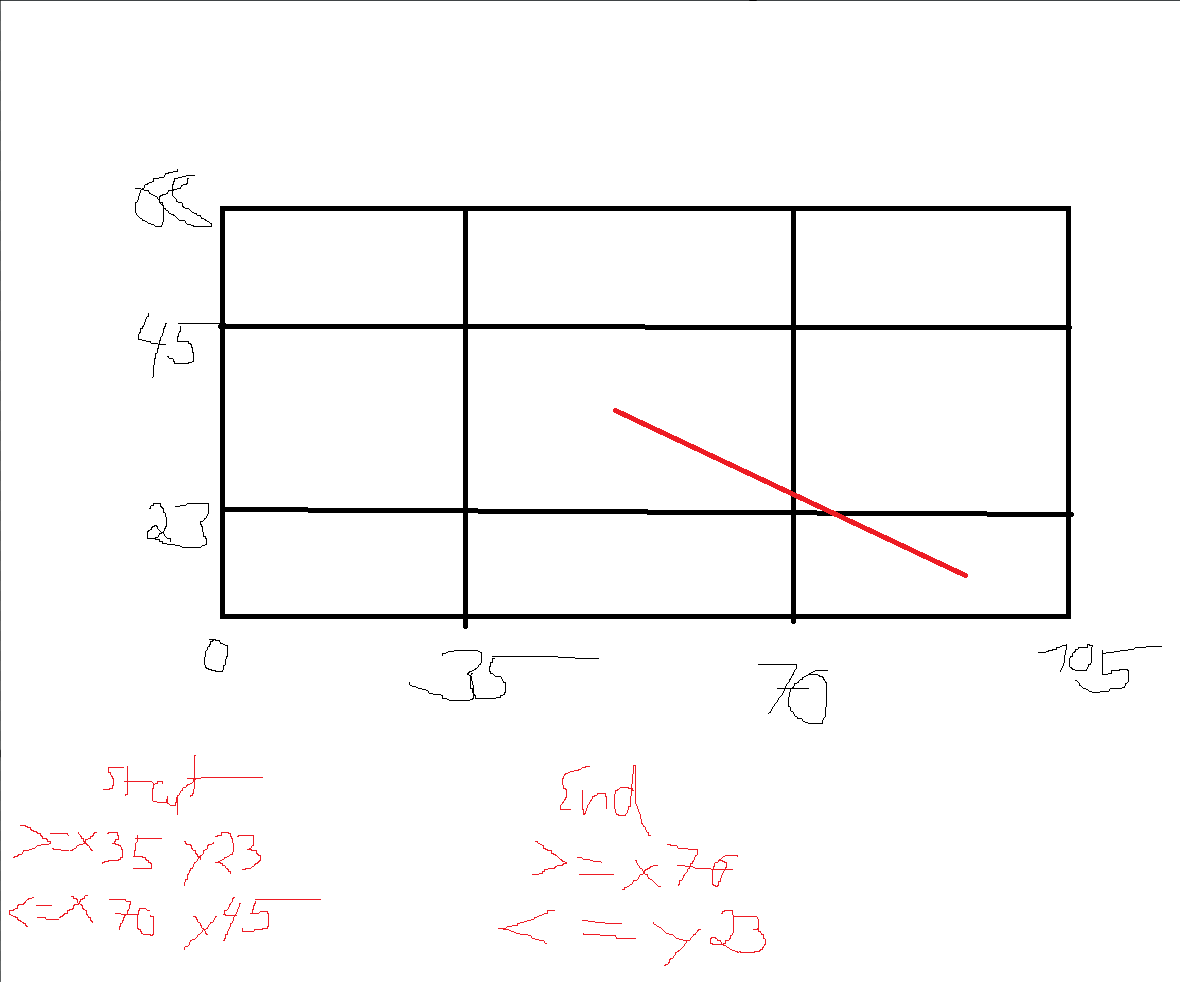

In [54]:
cols_to_add = [
         'vaep', 
         'vaep_adjusted',
         'vaep_offensiv',
         'vaep_adjusted_offensiv',
         'vaep_defensiv',          
         'vaep_adjusted_defensiv']

In [55]:
same_pass = all_actions_test[(all_actions_test['goal_side'] == "right")
                 &(all_actions_test['type_name'] == "pass")
                 &(all_actions_test['xSuccess'] >=0.45)
                 &(all_actions_test['xSuccess'] <=0.55)
                 &(all_actions_test['action_distance'] >= 20)
                 &(all_actions_test['action_distance'] <= 30)
                 &(all_actions_test['start_x'] >= 35)
                 &(all_actions_test['start_x'] <= 70)
                 &(all_actions_test['start_y'] >= 23)
                 &(all_actions_test['start_y'] <= 45)
                 &(all_actions_test['end_x'] >= 70)
                 &(all_actions_test['end_y'] <= 23)
                 ]
                
same_pass = same_pass.merge(compare_vaep_on_actions[['unique_id'] + cols_to_add], how='left', on='unique_id')

same_pass = same_pass[        
        ['unique_id',
         'game_id', 
         'player_name', 
         'team_name',
         'type_name',
         'action_distance',
         'result_id',
         'xSuccess',
         'xSuccess_with_player_id',         
         'vaep', 
         'vaep_adjusted',
         'vaep_offensiv',
         'vaep_adjusted_offensiv',
         'vaep_defensiv',          
         'vaep_adjusted_defensiv',
         'xG' ]]

cols_round = ['action_distance', 
        'xSuccess', 
        'xSuccess_with_player_id',
        'vaep',
        'vaep_adjusted', 
        'vaep_offensiv', 
        'vaep_adjusted_offensiv', 
        'vaep_defensiv', 
        'vaep_adjusted_defensiv']
 
same_pass[cols_round] = same_pass[cols_round].round(4)

In [56]:
same_pass_successful = same_pass[same_pass['result_id'] == 1]
same_pass_unsuccessful = same_pass[same_pass['result_id'] == 0] 

In [113]:
same_pass_successful.head(5)

,unique_id,game_id,player_name,team_name,type_name,action_distance,result_id,xSuccess,xSuccess_with_player_id,vaep,vaep_adjusted,vaep_offensiv,vaep_adjusted_offensiv,vaep_defensiv,vaep_adjusted_defensiv,xG
0,3754176_1550,3754176,Aaron Cresswell,West Ham United,pass,22.4475,1,0.4668,0.5626,0.0142,0.0286,0.0118,0.0290,0.0023,-0.0004,0.0
1,3829467_1185,3829467,Alaeddine Yahia,Caen,pass,27.2893,1,0.5484,0.7265,0.0109,0.0284,0.0090,0.0283,0.0019,0.0001,0.0
2,3829469_987,3829469,Fábio Henrique Tavares,AS Monaco,pass,24.0980,1,0.4682,0.6524,0.0043,0.0065,0.0041,0.0068,0.0002,-0.0002,0.0
3,3829499_950,3829499,Dennis Appiah,Caen,pass,20.5623,1,0.5414,0.7102,0.0142,0.0342,0.0123,0.0341,0.0020,0.0002,0.0
4,3879566_1088,3879566,Tomás Eduardo Rincón Hernández,Genoa,pass,23.4730,1,0.4623,0.5796,-0.0008,0.0048,-0.0015,0.0103,0.0007,-0.0055,0.0


In [114]:
same_pass_unsuccessful.head(5)

,unique_id,game_id,player_name,team_name,type_name,action_distance,result_id,xSuccess,xSuccess_with_player_id,vaep,vaep_adjusted,vaep_offensiv,vaep_adjusted_offensiv,vaep_defensiv,vaep_adjusted_defensiv,xG
6,3879661_1955,3879661,Maximiliano Nicol Moralez,Atalanta,pass,28.8400,0,0.5270,0.8909,-0.0026,0.0697,-0.0014,0.0685,-0.0012,0.0011,0.0
7,3879680_1874,3879680,Marios Oikonomou,Bologna,pass,29.0130,0,0.5153,0.8493,-0.0013,0.0631,0.0001,0.0616,-0.0014,0.0015,0.0
8,3879693_591,3879693,Francesco Lodi,Udinese,pass,20.9695,0,0.4547,0.4794,-0.0084,0.0203,-0.0058,0.0196,-0.0026,0.0007,0.0
10,3879744_776,3879744,Andrea Ranocchia,Sampdoria,pass,25.5439,0,0.4817,0.4516,-0.0063,0.0460,-0.0059,0.0462,-0.0004,-0.0002,0.0
11,3879747_601,3879747,Godfred Donsah,Bologna,pass,20.7804,0,0.5382,0.5861,-0.0068,0.0073,-0.0075,0.0075,0.0006,-0.0001,0.0


In [59]:
#compare_vaep_on_actions.to_csv("test_daten.csv", index=False)

## Grafiken ausgeben und speichern

### vaep_adjusted (plus-minus) mit vaep mit dribblings

# Erstelle deine Grafik
ax = compare_vaep_on_actions.plot.scatter(x="vaep_adjusted", y="vaep", c="xSuccess")
plt.title("Scatterplot: vaep_adjusted vs vaep with xSuccess")  # optional ein Titel
plt.show()

# Speichere PLot im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_-_vaep_-_xSuccess.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions.plot.scatter(x="vaep_adjusted", y="vaep", c="result_id", cmap="viridis")
plt.title("Scatterplot: vaep_adjusted vs vaep with result_id")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_-_vaep_-_result_id.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

### vaep_adjusted_offensiv(plus) mit vaep_offensiv mit dribblings

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions.plot.scatter(x="vaep_adjusted_offensiv", y="vaep_offensiv", c= "xSuccess")
plt.title("Scatterplot: vaep_adjusted_offensiv vs vaep_offensiv with xSuccess")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_offensiv_-_vaep_offensiv_-_xSuccess.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

### vaep_adjusted_defensiv(minus) mit vaep_defensiv mit dribblings

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions.plot.scatter(x="vaep_adjusted_defensiv", y="vaep_defensiv", c="xSuccess")
plt.title("Scatterplot: vaep_adjusted_defensiv vs vaep_defensiv with xSuccess")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_defensiv_-_vaep_defensiv_-_xSuccess.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions.plot.scatter(x="vaep_adjusted_defensiv", y="vaep_defensiv", c="result_id", cmap="viridis")
plt.title("Scatterplot: vaep_adjusted_defensiv vs vaep_defensiv with result_id")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_defensiv_-_vaep_defensiv_-_result_id.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

### Dribblings herausfiltern

In [60]:
compare_vaep_on_actions_no_dribble = compare_vaep_on_actions[(compare_vaep_on_actions['type_name'] != 'dribble')]

### vaep_adjusted (plus-minus) mit vaep ohne dribblings

# Erstelle deine Grafik
ax = compare_vaep_on_actions_no_dribble.plot.scatter(x="vaep_adjusted", y="vaep", c="xSuccess")
plt.title("Scatterplot: vaep_adjusted vs vaep with xSuccess")  # optional ein Titel
plt.show()

# Speichere PLot im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_-_vaep_-_xSuccess_-_no_dribble.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

### vaep_adjusted_offensiv(plus) mit vaep_offensiv ohne dribblings

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions_no_dribble.plot.scatter(x="vaep_adjusted_offensiv", y="vaep_offensiv", c= "xSuccess", colormap="viridis")
plt.title("Scatterplot: vaep_adjusted_offensiv vs vaep_offensiv with xSuccess")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_offensiv_-_vaep_offensiv_-_xSuccess_-_no_dribble.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

### vaep_adjusted_defensiv(minus) mit vaep_defensiv ohne dribblings

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions_no_dribble.plot.scatter(x="vaep_adjusted_defensiv", y="vaep_defensiv", c="xSuccess", colormap="viridis")
plt.title("Scatterplot: vaep_adjusted_defensiv vs vaep_defensiv with xSuccess")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_vaep_adjusted_defensiv_-_vaep_defensiv_-_xSuccess_-_no_dribble.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

Falls nötig, Dataframe als csv speichern

Histogram von vaep_adjusted_offensiv ausgeben und speichern

ax = compare_vaep_on_actions["vaep_adjusted_offensiv"].hist()
plt.title("Histogram: VAEP_adjusted_offensiv")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "hist_vaep_adjusted_offensiv.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)


Histogram von vaep_adjusted_defensiv ausgeben und speichern

ax = compare_vaep_on_actions["vaep_adjusted_defensiv"].hist()
plt.title("Histogram: vaep_adjusted_defensiv")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "hist_vaep_adjusted_defensiv.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)


Scatterplot von xSuccess und differenz_minus ausgeben und speichern

# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions.plot.scatter(x="xSuccess", y="differenz_vaep_adjusted_defensiv")
plt.title("Scatterplot: xSuccess vs differenz_vaep_adjusted_defensiv")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_xSuccess_-_differenz_vaep_adjusted_defensiv.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

Scatterplot von xSuccess und differenz_plus ausgeben und speichern


# Erstelle deine Grafik, z.B. ein Scatterplot
ax = compare_vaep_on_actions.plot.scatter(x="xSuccess", y="differenz_vaep_adjusted_offensiv")
plt.title("Scatterplot: xSuccess vs differenz_vaep_adjusted_offensiv")  # optional ein Titel
plt.show()

# Hole die aktuelle Figur aus dem Plot und speichere sie im Unterordner
fig = ax.get_figure()
save_path = os.path.join(subfolder, "scatter_xSuccess_differenz_-_vaep_adjusted_offensiv.png")
fig.savefig(save_path, dpi=300)
plt.close(fig)

## VAEP von bestimmten Spieler über die gesamte Saison

In [ ]:
cols_order = [
    'player_id', 
    'player_name',
    'team_id', 
    'team_name',
    "starting_position_name",
    'competition_id', 
    'competition_name',
    'season_vaep_total',
    'season_xG_total',
    'season_xG_avg',
    'season_xSuccess_mean',
    "season_xSuccess_with_player_id_mean",
    'season_vaep_adjusted_total',
    'season_offense_total',
    'season_defense_total', 
    'total_minutes_played',
    ]

player_meta = (
    compare_vaep_on_actions[
        ["player_id","player_name","team_id","team_name","starting_position_name",
         "competition_id","competition_name"]
    ]
    .drop_duplicates(subset="player_id")
)


# Aktionstypen
action_types = ["pass", "cross", "dribble", "shot"]

# Minuten pro Spieler aggregieren
minutes = (
    player_games
    .groupby("player_id", as_index=False)["minutes_played"]
    .sum()
    .rename(columns={"minutes_played": "total_minutes_played"})
)

# Resultate in einem Dict sammeln
action_stats = {}

for action in action_types:
    # Nur diese Aktion herausfiltern
    df_act = compare_vaep_on_actions[
        compare_vaep_on_actions["type_name"] == action
    ]
    
    # Pro Spieler aggregieren
    agg = (
        df_act
        .groupby(["player_id", "player_name"], as_index=False)
        .agg(
            starting_position       = ('starting_position_name',lambda x: x.value_counts().idxmax()),
            season_xG_total                             = ("xG",                            "sum"),
            season_xG_avg                               = ("xG",                            "mean"),
            season_xSuccess_mean                        = ("xSuccess",                      "mean"),
            season_xSuccess_with_player_id_mean         = ("xSuccess_with_player_id",       "mean"),
            season_vaep_total                           = ("vaep",                          "sum"),
            season_vaep_adjusted_total                  = ("vaep_adjusted",                 "sum"),
            season_offense_total                        = ("vaep_offensiv",                 "sum"),
            season_defense_total                        = ("vaep_defensiv",                 "sum"),
        )
    )
    
    # Minuten und vaep_per_90 dazuholen
    df = (
        agg
        .merge(minutes, on="player_id", how="left")
        .merge(player_meta,  on=["player_id","player_name"], how="left")
    )

    
    df = df[cols_order]

    # 3d) In dict speichern
    action_stats[action] = df.reset_index(drop=True)

pass_stats   = action_stats["pass"]
cross_stats  = action_stats["cross"]
dribble_stats= action_stats["dribble"]
shot_stats   = action_stats["shot"] # alle Schüsse, nicht nur erfolgreiche


- Kroos (5574) 
- Modric (5463)
- Gündogan (10287)

variable anzahl der aktionen\
anzahl gesamte tore

In [100]:
player_ids = [5574, 5463, 10287]

pass_stats_group_1    = pass_stats   [ pass_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)
cross_stats_group_1   = cross_stats  [ cross_stats ["player_id"].isin(player_ids) ].reset_index(drop=True)
dribble_stats_group_1 = dribble_stats[ dribble_stats["player_id"].isin(player_ids) ].reset_index(drop=True)
shot_stats_group_1    = shot_stats   [ shot_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)

In [123]:
pass_stats_group_1

,player_id,player_name,team_id,team_name,starting_position_name,competition_id,competition_name,season_vaep_total,season_xG_total,season_xG_avg,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
0,5463,Luka Modrić,220,Real Madrid,Right Defensive Midfield,11,La Liga,2.756253,0.0,0.0,0.869110,0.900771,10.814106,2.554928,0.201325,1463
1,5574,Toni Kroos,220,Real Madrid,Left Defensive Midfield,11,La Liga,2.677651,0.0,0.0,0.884691,0.873246,8.161416,2.519157,0.158494,1576
2,10287,İlkay Gündoğan,180,Borussia Dortmund,Right Defensive Midfield,9,1. Bundesliga,2.271880,0.0,0.0,0.865096,0.862688,9.920201,2.261311,0.010569,1095


In [102]:
shot_stats_group_1

,player_id,player_name,team_id,team_name,starting_position_name,competition_id,competition_name,season_vaep_total,season_xG_total,season_xG_avg,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
0,5463,Luka Modrić,220,Real Madrid,Right Defensive Midfield,11,La Liga,0.115136,1.184350,0.056398,0.016239,0.034373,0.266100,0.146461,-0.031325,1463
1,5574,Toni Kroos,220,Real Madrid,Left Defensive Midfield,11,La Liga,0.593326,0.631607,0.052634,0.071990,0.059980,0.723675,0.611827,-0.018501,1576
2,10287,İlkay Gündoğan,180,Borussia Dortmund,Right Defensive Midfield,9,1. Bundesliga,-0.130232,2.034899,0.081396,0.051355,0.055017,0.796069,-0.095906,-0.034327,1095


Eriksen (3043) - Özil (3496) - Iniest (5216)

In [97]:
player_ids = [3043, 3496, 5216]

pass_stats_group_2    = pass_stats   [ pass_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)
cross_stats_group_2   = cross_stats  [ cross_stats ["player_id"].isin(player_ids) ].reset_index(drop=True)
dribble_stats_group_2 = dribble_stats[ dribble_stats["player_id"].isin(player_ids) ].reset_index(drop=True)
shot_stats_group_2    = shot_stats   [ shot_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)

In [124]:
pass_stats_group_2

,player_id,player_name,team_id,team_name,starting_position_name,competition_id,competition_name,season_vaep_total,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
0,3043,Christian Dannemann Eriksen,38,Tottenham Hotspur,Left Wing,2,Premier League,1.004955,0.820344,0.681869,10.409066,0.982941,0.022014,1454
1,3496,Mesut Özil,1,Arsenal,Center Attacking Midfield,2,Premier League,3.139339,0.836457,0.898703,18.629135,3.181251,-0.041912,1791
2,5216,Andrés Iniesta Luján,217,Barcelona,Substitute,11,La Liga,2.247526,0.867447,0.866744,8.943727,2.162610,0.084916,1101


Vidal (8206) - Matuidi (4375) - Pogba (20004)

In [125]:
player_ids = [8206, 4375, 20004]

pass_stats_group_3    = pass_stats   [ pass_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)
cross_stats_group_3   = cross_stats  [ cross_stats ["player_id"].isin(player_ids) ].reset_index(drop=True)
dribble_stats_group_3 = dribble_stats[ dribble_stats["player_id"].isin(player_ids) ].reset_index(drop=True)
shot_stats_group_3    = shot_stats   [ shot_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)

In [128]:
shot_stats_group_3

,player_id,player_name,team_id,team_name,starting_position_name,competition_id,competition_name,season_vaep_total,season_xG_total,season_xG_avg,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
0,4375,Blaise Matuidi,131,Paris Saint-Germain,Left Center Midfield,7,Ligue 1,0.226652,1.002338,0.125292,0.179984,0.112285,0.752036,0.231564,-0.004912,889
1,8206,Arturo Erasmo Vidal Pardo,169,Bayern Munich,Left Center Midfield,9,1. Bundesliga,0.050607,1.122252,0.051011,0.106231,0.095359,1.690196,0.083449,-0.032842,819
2,20004,Paul Pogba,224,Juventus,Left Center Midfield,12,Serie A,-0.284072,3.434809,0.060260,0.043327,0.038527,1.477681,-0.182797,-0.101275,1639


Benzema (19677) - Firmino (3535) - Dybala (5743) - Griezmann (5487)

In [129]:
player_ids = [19677, 3535, 5743, 5487]

pass_stats_group_4    = pass_stats   [ pass_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)
cross_stats_group_4   = cross_stats  [ cross_stats ["player_id"].isin(player_ids) ].reset_index(drop=True)
dribble_stats_group_4 = dribble_stats[ dribble_stats["player_id"].isin(player_ids) ].reset_index(drop=True)
shot_stats_group_4    = shot_stats   [ shot_stats  ["player_id"].isin(player_ids) ].reset_index(drop=True)

In [130]:
shot_stats_group_4

,player_id,player_name,team_id,team_name,starting_position_name,competition_id,competition_name,season_vaep_total,season_xG_total,season_xG_avg,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
0,3535,Roberto Firmino Barbosa de Oliveira,24,Liverpool,Right Wing,2,Premier League,2.464415,4.389352,0.133011,0.108529,0.082674,2.805175,2.503146,-0.038731,1238
1,5487,Antoine Griezmann,212,Atlético Madrid,Left Center Forward,11,La Liga,6.286365,7.220721,0.164107,0.147418,0.148201,4.203130,6.335143,-0.048778,2013
2,5743,Paulo Bruno Exequiel Dybala,224,Juventus,Substitute,12,Serie A,2.436399,5.334281,0.102582,0.088092,0.057345,2.645344,2.510044,-0.073645,1306
3,19677,Karim Benzema,220,Real Madrid,Center Forward,11,La Liga,6.564583,10.577803,0.195885,0.214761,0.224422,6.631918,6.607703,-0.043121,1077


- Drei Spieler vergleichen, bekomme ich noch von Yannik
  - wie im Paper mit den Balken
  - VAEP und xSuccess
  - Kroos - Modric - Gündogan
  - Eriksen - Özil - Iniest
  - Vidal - Matuidi - Pogba
  - Benzema - Firmino - Dybala - Griezmann

## VAEP von Spielerpositionen (Defensiv - Midfield - Forward)

Sortieren nach Spielerposition

In [70]:
# Maske: alle Rows, in denen ‚Back‘ in starting_position_name steht
mask = ~compare_vaep_on_actions["starting_position_name"] \
            .str.contains("Wing", case=False, na=False)

# 1) Filtern, 2) nach starting_position_name sortieren, 3) Index zurücksetzen
Positions_without_wings = (
    compare_vaep_on_actions
    .loc[mask]                          # <-- alle Spalten
    .sort_values("starting_position_name", ascending=True)
    .reset_index(drop=True)
)

# Ausgabe: zeigt nun alle Spalten von Positions_without_wings
Positions_without_wings.columns

Index(['unique_id', 'game_id', 'competition_id', 'competition_name',
       'player_id', 'player_name', 'team_id', 'team_name',
       'starting_position_id', 'starting_position_name', 'minutes_played',
       'action_id', 'type_name', 'result_id', 'xSuccess',
       'xSuccess_with_player_id', 'xG', 'vaep', 'vaep_adjusted',
       'vaep_offensiv', 'vaep_defensiv', 'vaep_adjusted_offensiv',
       'vaep_adjusted_defensiv', 'vaep_success', 'vaep_success_off',
       'vaep_success_def', 'vaep_fail', 'vaep_fail_off', 'vaep_fail_def',
       'differenz_vaep_adjusted_defensiv', 'differenz_vaep_adjusted_offensiv'],
      dtype='object')

In [71]:
# Maske: alle Rows, in denen ‚Back‘ in starting_position_name steht
mask = Positions_without_wings["starting_position_name"] \
            .str.contains("back", case=False, na=False)

# 1) Filtern, 2) nach starting_position_name sortieren, 3) Index zurücksetzen
Positions_back = (
    Positions_without_wings
    .loc[mask]                          # <-- alle Spalten
    .sort_values("starting_position_name", ascending=True)
    .reset_index(drop=True)
)

# Ausgabe: zeigt nun alle Spalten von Position_1
Positions_back['starting_position_name'].unique()

array(['Center Back', 'Left Back', 'Left Center Back', 'Right Back',
       'Right Center Back'], dtype=object)

In [72]:
# Maske: alle Rows, in denen ‚Back‘ in starting_position_name steht
mask = Positions_without_wings["starting_position_name"] \
            .str.contains("Midfield", case=False, na=False)

# 1) Filtern, 2) nach starting_position_name sortieren, 3) Index zurücksetzen
Positions_midfield = (
    Positions_without_wings
    .loc[mask]                          # <-- alle Spalten
    .sort_values("starting_position_name", ascending=True)
    .reset_index(drop=True)
)

# Ausgabe: zeigt nun alle Spalten von Position_1
Positions_midfield['starting_position_name'].unique()

array(['Center Attacking Midfield', 'Center Defensive Midfield',
       'Left Attacking Midfield', 'Left Center Midfield',
       'Left Defensive Midfield', 'Left Midfield',
       'Right Attacking Midfield', 'Right Center Midfield',
       'Right Defensive Midfield', 'Right Midfield'], dtype=object)

In [73]:
# Maske: alle Rows, in denen ‚Back‘ in starting_position_name steht
mask = Positions_without_wings["starting_position_name"] \
            .str.contains("forward", case=False, na=False)

# 1) Filtern, 2) nach starting_position_name sortieren, 3) Index zurücksetzen
Positions_forward = (
    Positions_without_wings
    .loc[mask]                          # <-- alle Spalten
    .sort_values("starting_position_name", ascending=True)
    .reset_index(drop=True)
)

# Ausgabe: zeigt nun alle Spalten von Position_1
Positions_forward['starting_position_name'].unique()

array(['Center Forward', 'Left Center Forward', 'Right Center Forward'],
      dtype=object)

## Aktionen nach Position filtern

In [103]:
cols_order = [
    'player_id', 
    'player_name',
    'starting_position_name',
    'team_id', 
    'team_name',
    'competition_id', 
    'competition_name',
    'season_xG_total' ,
    'season_xG_avg',
    'season_vaep_total',
    'season_xSuccess_mean',
    "season_xSuccess_with_player_id_mean", 
    'season_vaep_adjusted_total',
    'season_offense_total',
    'season_defense_total', 
    'total_minutes_played',
    ]

In [104]:
player_meta = (
    Positions_back[
        ["player_id","player_name","team_id","team_name","starting_position_name",
         "competition_id","competition_name"]
    ]
    .drop_duplicates(subset="player_id")
)

# Aktionstypen
action_types = ["pass", "cross", "dribble", "shot"]

# Minuten pro Spieler aggregieren
minutes = (
    player_games
    .groupby("player_id", as_index=False)["minutes_played"]
    .sum()
    .rename(columns={"minutes_played": "total_minutes_played"})
)

# Resultate in einem Dict sammeln
action_stats = {}

for action in action_types:
    # Nur diese Aktion herausfiltern
    df_act = Positions_back[
        Positions_back["type_name"] == action
    ]
    
    # Pro Spieler aggregieren
    agg = (
        df_act
        .groupby(["player_id", "player_name"], as_index=False)
        .agg(
            starting_position       = ('starting_position_name',lambda x: x.value_counts().idxmax()),
            season_xG_total                             = ("xG",                            "sum"),
            season_xG_avg                               = ("xG",                            "mean"),
            season_xSuccess_mean                        = ("xSuccess",                      "mean"),
            season_xSuccess_with_player_id_mean         = ("xSuccess_with_player_id",       "mean"),
            season_vaep_total                           = ("vaep",                          "sum"),
            season_vaep_adjusted_total                  = ("vaep_adjusted",                 "sum"),
            season_offense_total                        = ("vaep_offensiv",                 "sum"),
            season_defense_total                        = ("vaep_defensiv",                 "sum"),
        )
    )
    
    # Minuten und vaep_per_90 dazuholen
    df = (
        agg
        .merge(minutes, on="player_id", how="left")
        .merge(player_meta,  on=["player_id","player_name"], how="left")
    )
    
    df = df[cols_order]

    # 3d) In dict speichern
    action_stats[action] = df.reset_index(drop=True)

pass_stats_back   = action_stats["pass"]
cross_stats_back  = action_stats["cross"]
dribble_stats_back= action_stats["dribble"]
shot_stats_back   = action_stats["shot"]

In [106]:
player_meta = (
    Positions_midfield[
        ["player_id","player_name","team_id","team_name","starting_position_name",
         "competition_id","competition_name"]
    ]
    .drop_duplicates(subset="player_id")
)

# Aktionstypen
action_types = ["pass", "cross", "dribble", "shot"]

# Minuten pro Spieler aggregieren
minutes = (
    player_games
    .groupby("player_id", as_index=False)["minutes_played"]
    .sum()
    .rename(columns={"minutes_played": "total_minutes_played"})
)

# Resultate in einem Dict sammeln
action_stats = {}

for action in action_types:
    # Nur diese Aktion herausfiltern
    df_act = Positions_midfield[
        Positions_midfield["type_name"] == action
    ]
    
    # Pro Spieler aggregieren
    agg = (
        df_act
        .groupby(["player_id", "player_name"], as_index=False)
        .agg(
            starting_position       = ('starting_position_name',lambda x: x.value_counts().idxmax()),
            season_xG_total                             = ("xG",                            "sum"),
            season_xG_avg                               = ("xG",                            "mean"),
            season_xSuccess_mean                        = ("xSuccess",                      "mean"),
            season_xSuccess_with_player_id_mean         = ("xSuccess_with_player_id",       "mean"),
            season_vaep_total                           = ("vaep",                          "sum"),
            season_vaep_adjusted_total                  = ("vaep_adjusted",                 "sum"),
            season_offense_total                        = ("vaep_offensiv",                 "sum"),
            season_defense_total                        = ("vaep_defensiv",                 "sum"),
        )
    )
    
    # Minuten und vaep_per_90 dazuholen
    df = (
        agg
        .merge(minutes, on="player_id", how="left")
        .merge(player_meta,  on=["player_id","player_name"], how="left")
    )
    
    df = df[cols_order]

    # 3d) In dict speichern
    action_stats[action] = df.reset_index(drop=True)

pass_stats_midfield  = action_stats["pass"]
cross_stats_midfield  = action_stats["cross"]
dribble_stats_midfield= action_stats["dribble"]
shot_stats_midfield   = action_stats["shot"]

In [107]:
player_meta = (
    Positions_forward[
        ["player_id","player_name","team_id","team_name","starting_position_name",
         "competition_id","competition_name"]
    ]
    .drop_duplicates(subset="player_id")
)

# Aktionstypen
action_types = ["pass", "cross", "dribble", "shot"]

# Minuten pro Spieler aggregieren
minutes = (
    player_games
    .groupby("player_id", as_index=False)["minutes_played"]
    .sum()
    .rename(columns={"minutes_played": "total_minutes_played"})
)

# Resultate in einem Dict sammeln
action_stats = {}

for action in action_types:
    # Nur diese Aktion herausfiltern
    df_act = Positions_forward[
        Positions_forward["type_name"] == action
    ]
    
    # Pro Spieler aggregieren
    agg = (
        df_act
        .groupby(["player_id", "player_name"], as_index=False)
        .agg(
            starting_position       = ('starting_position_name',lambda x: x.value_counts().idxmax()),
            season_xG_total                             = ("xG",                            "sum"),
            season_xG_avg                               = ("xG",                            "mean"),
            season_xSuccess_mean                        = ("xSuccess",                      "mean"),
            season_xSuccess_with_player_id_mean         = ("xSuccess_with_player_id",       "mean"),
            season_vaep_total                           = ("vaep",                          "sum"),
            season_vaep_adjusted_total                  = ("vaep_adjusted",                 "sum"),
            season_offense_total                        = ("vaep_offensiv",                 "sum"),
            season_defense_total                        = ("vaep_defensiv",                 "sum"),
        )
    )
    
    # Minuten und vaep_per_90 dazuholen
    df = (
        agg
        .merge(minutes, on="player_id", how="left")
        .merge(player_meta,  on=["player_id","player_name"], how="left")
    )
    
    df = df[cols_order]

    # 3d) In dict speichern
    action_stats[action] = df.reset_index(drop=True)

pass_stats_forward  = action_stats["pass"]
cross_stats_forward  = action_stats["cross"]
dribble_stats_forward= action_stats["dribble"]
shot_stats_forward   = action_stats["shot"]

## Ergebnis

alle Abwehrspieler durschnittswerte ermitteln\
werte durch die anzahl der spieler oder aktionen teilen\
variable: anzahl der aktionen pro spieler im durschnitt vielleicht

alle variablen auf 90 minuten normieren\

beispiel: season_vaep_per_90_minutes

alle werte aufsummieren und durch die spieler teilen

dann nochmal auf 90 minuten runter brechen

ein durschnittlicher abwehrspieler in 90 minuten

### Abwehr

über alle aktionen den xSuccesswert und xSuccess with player id mittelwert ermitteln und vergleichen

In [170]:
pass_stats_back.sort_values("season_vaep_total", ascending=False)
#cross_stats_back.sort_values("season_vaep_total", ascending=False)
#dribble_stats_back.sort_values("season_vaep_total", ascending=False)
#shot_stats_back.sort_values("season_vaep_total", ascending=False)

,player_id,player_name,starting_position_name,team_id,team_name,competition_id,competition_name,season_xG_total,season_xG_avg,season_vaep_total,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
63,3295,Thiago Emiliano da Silva,Left Center Back,131,Paris Saint-Germain,7,Ligue 1,0.0,0.0,3.080477,0.875471,0.885982,6.089831,2.556876,0.523601,1395
394,7151,Mário Rui Silva Duarte,Left Back,290,Empoli,12,Serie A,0.0,0.0,3.003712,0.781361,0.716136,15.840540,3.208384,-0.204672,2543
402,7173,Leonardo Bonucci,Center Back,224,Juventus,12,Serie A,0.0,0.0,2.836933,0.819048,0.841209,9.698695,2.582521,0.254411,1891
582,10805,Ricardo Alberto Silveira de Carvalho,Left Center Back,129,AS Monaco,7,Ligue 1,0.0,0.0,2.414685,0.835477,0.901560,5.277067,1.814906,0.599780,1929
260,5675,Kalidou Koulibaly,Left Center Back,227,Napoli,12,Serie A,0.0,0.0,2.344195,0.839123,0.837207,8.677323,2.011971,0.332224,1717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,24138,Joaquín José Marín Ruiz,Right Back,360,Rayo Vallecano,11,La Liga,0.0,0.0,-0.169037,0.709503,0.704083,1.742812,-0.032921,-0.136116,1126
315,6716,Sébastien Corchia,Right Back,143,Lille,7,Ligue 1,0.0,0.0,-0.178098,0.698352,0.714533,0.595563,-0.110854,-0.067245,702
311,6699,Ander Capa Rodríguez,Right Back,322,Eibar,11,La Liga,0.0,0.0,-0.182437,0.671600,0.683321,6.560803,0.006214,-0.188651,1796
795,40366,Wes Brown,Left Center Back,41,Sunderland,2,Premier League,0.0,0.0,-0.199578,0.715994,0.717728,0.586603,-0.190885,-0.008693,289


### Mittelfeld

In [168]:
#pass_stats_midfield.sort_values("season_vaep_total", ascending=False)
#cross_stats_midfield.sort_values("season_vaep_total", ascending=False)
#dribble_stats_midfield.sort_values("season_vaep_total", ascending=False)
shot_stats_midfield.sort_values("season_vaep_total", ascending=False)

,player_id,player_name,starting_position_name,team_id,team_name,competition_id,competition_name,season_xG_total,season_xG_avg,season_vaep_total,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
130,3567,Georginio Wijnaldum,Center Attacking Midfield,37,Newcastle United,2,Premier League,4.200308,0.150011,4.994388,0.229735,0.301596,4.530592,5.026739,-0.032351,2017
374,6852,Jozabed Sánchez Ruiz,Center Attacking Midfield,360,Rayo Vallecano,11,La Liga,3.660337,0.159145,4.713689,0.150155,0.175236,2.964436,4.737956,-0.024267,1130
86,3348,Younousse Sankharé,Left Center Midfield,142,Guingamp,7,Ligue 1,1.257969,0.089855,4.220388,0.152170,0.131481,1.728809,4.232362,-0.011974,1423
168,3874,Mark Noble,Center Defensive Midfield,40,West Ham United,2,Premier League,0.837664,0.069805,3.161704,0.234628,0.163123,2.179529,3.171655,-0.009950,1317
249,5562,Thomas Müller,Center Attacking Midfield,169,Bayern Munich,9,1. Bundesliga,4.297435,0.148187,2.973900,0.119226,0.065919,1.622354,3.009257,-0.035357,1137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,3294,Juan Manuel Mata García,Center Attacking Midfield,39,Manchester United,2,Premier League,1.384932,0.106533,-0.915139,0.057792,0.061912,0.551982,-0.891074,-0.024065,1069
674,15893,Víctor Rodríguez Romero,Center Attacking Midfield,216,Getafe,11,La Liga,1.394799,0.058117,-0.923624,0.061165,0.050756,1.187695,-0.886256,-0.037368,1487
268,5678,Jefferson Andrés Lerma Solís,Left Center Midfield,221,Levante UD,11,La Liga,1.281273,0.055708,-1.106015,0.047460,0.046426,1.018883,-1.075159,-0.030856,1968
301,6389,Mikel San José Domínguez,Left Defensive Midfield,215,Athletic Club,11,La Liga,1.347012,0.089801,-1.213388,0.046832,0.049819,0.465523,-1.193224,-0.020164,1645


### Sturm

In [110]:
#pass_stats_forward.sort_values("season_vaep_total", ascending=False)
#cross_stats_forward.sort_values("season_vaep_total", ascending=False)
#dribble_stats_forward.sort_values("season_vaep_total", ascending=False)
shot_stats_forward.sort_values("season_vaep_total", ascending=False)

,player_id,player_name,starting_position_name,team_id,team_name,competition_id,competition_name,season_xG_total,season_xG_avg,season_vaep_total,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
75,3672,Zlatan Ibrahimović,Center Forward,131,Paris Saint-Germain,7,Ligue 1,9.820169,0.172284,14.273760,0.245941,0.259577,8.949814,14.317686,-0.043926,1122
110,5497,Gonzalo Gerardo Higuaín,Center Forward,227,Napoli,12,Serie A,12.087871,0.122100,9.699581,0.129556,0.086902,8.007625,9.815645,-0.116064,1776
10,3058,Javier Hernández Balcázar,Center Forward,904,Bayer Leverkusen,9,1. Bundesliga,6.455884,0.280691,7.764187,0.320336,0.226971,4.990019,7.776101,-0.011914,884
367,40252,Massimo Maccarone,Left Center Forward,290,Empoli,12,Serie A,6.406667,0.098564,6.738597,0.114862,0.160045,5.159350,6.805387,-0.066790,2013
301,19677,Karim Benzema,Center Forward,220,Real Madrid,11,La Liga,10.550974,0.199075,6.640052,0.218626,0.228148,6.626827,6.681388,-0.041336,1077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,23416,Stefan Šćepović,Center Forward,216,Getafe,11,La Liga,2.167499,0.144500,-1.351438,0.032914,0.028282,0.364977,-1.331802,-0.019636,1216
112,5543,Haris Seferović,Center Forward,184,Eintracht Frankfurt,9,1. Bundesliga,2.522323,0.105097,-1.381121,0.048197,0.061935,0.801063,-1.344907,-0.036214,1045
152,6686,Giampaolo Pazzini,Center Forward,226,Hellas Verona,12,Serie A,3.120560,0.089159,-2.102103,0.066690,0.074564,1.362448,-2.056696,-0.045407,1068
308,20252,Luca Toni,Center Forward,226,Hellas Verona,12,Serie A,4.706551,0.151824,-2.274058,0.026566,0.032192,0.483699,-2.234756,-0.039302,979


In [81]:
def plot_competition_scatter(
    df,
    x_col,
    y_col,
    competition=None
):
    """
    Erzeugt einen Scatter-Plot für Spieler in einer bestimmten competition_name.
    Wenn competition=None, wird ein einziger Plot für alle Wettbewerbe zusammen erstellt.
    
    Parameter:
    -----------
    df : pd.DataFrame
        DataFrame mit mindestens den Spalten
        ['competition_name', x_col, y_col, 'player_id', 'season_xSuccess_mean'].
    x_col : str
        Spaltenname für die x-Achse.
    y_col : str
        Spaltenname für die y-Achse.
    competition : str oder None, default=None
        Name der Liga / Competition, oder None für alle Wettbewerbe.
    """
    # Filter (optional)
    if competition is not None:
        df_sub = df[df["competition_name"] == competition].copy()
        if df_sub.empty:
            raise ValueError(f"Kein Eintrag für competition_name={competition} gefunden.")
        title_prefix = competition
    else:
        df_sub = df.copy()
        title_prefix = "Alle Wettbewerbe"

    # Plot aufsetzen
    fig, ax = plt.subplots(figsize=(8,6))
    scatter = ax.scatter(
        df_sub[x_col],
        df_sub[y_col],
        c=df_sub["season_xSuccess_mean"],  # Farbe nach season_xSuccess_mean
        cmap="viridis",
        s=50,
        edgecolor="k"
    )
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("season_xSuccess_mean")

    # Achsen und Titel
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{title_prefix}: {y_col} vs. {x_col}")

    # player_id annotieren
    for _, row in df_sub.iterrows():
        ax.annotate(
            int(row["player_id"]),
            (row[x_col], row[y_col]),
            textcoords="offset points",
            xytext=(5,5),
            ha="left",
            fontsize=8,
            color="black"
        )

    plt.tight_layout()
    plt.show()


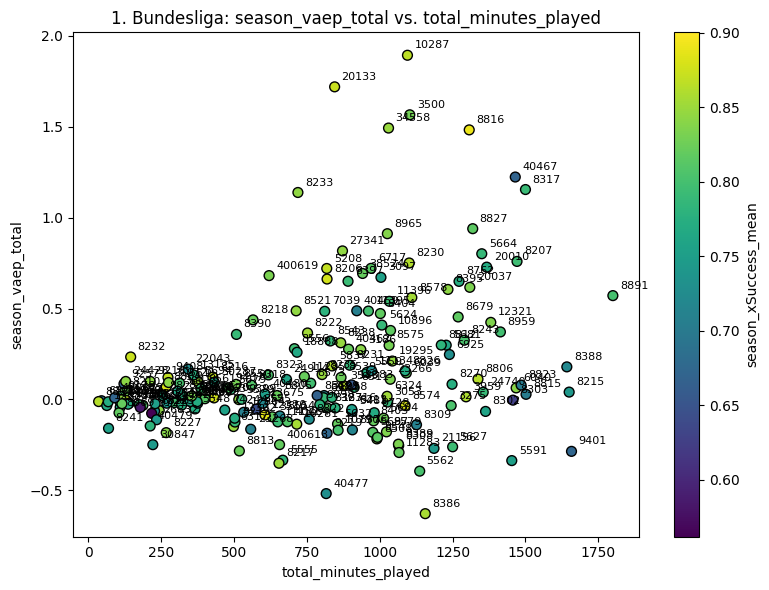

In [82]:
# Angenommen, Du hast bereits das DataFrame shot_stats_forward
plot_competition_scatter(
    df             = pass_stats_midfield,
    competition    = "1. Bundesliga",
    x_col          = "total_minutes_played",
    y_col          = "season_vaep_total"
)

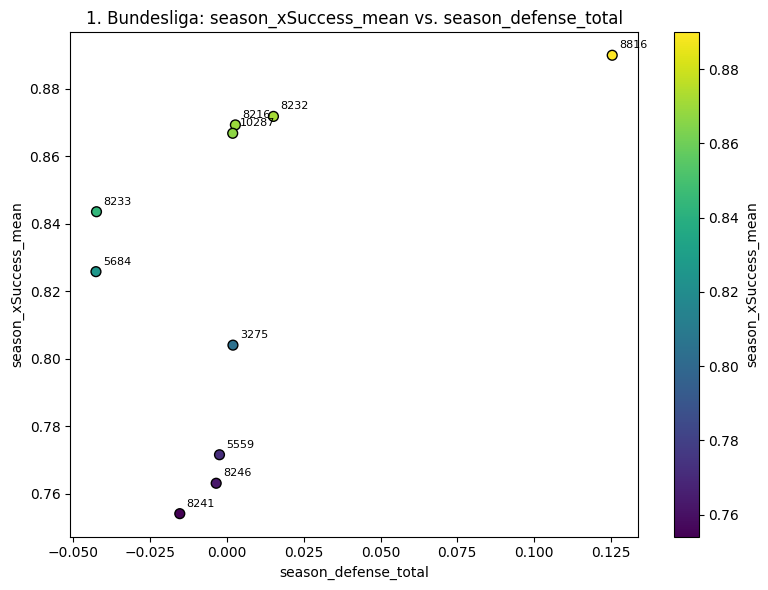

In [83]:
# Angenommen, Du hast bereits das DataFrame shot_stats_forward
plot_competition_scatter(
    df             = pass_stats_midfield[pass_stats_midfield['team_name']== 'Borussia Dortmund'],
    competition    = "1. Bundesliga",
    x_col          = "season_defense_total",
    y_col          = "season_xSuccess_mean"
)

In [149]:
pass_stats_midfield[pass_stats_midfield['player_id']==8816]

,player_id,player_name,starting_position_name,team_id,team_name,competition_id,competition_name,season_xG_total,season_xG_avg,season_vaep_total,season_xSuccess_mean,season_xSuccess_with_player_id_mean,season_vaep_adjusted_total,season_offense_total,season_defense_total,total_minutes_played
626,8816,Julian Weigl,Center Defensive Midfield,180,Borussia Dortmund,9,1. Bundesliga,0.0,0.0,1.482586,0.889906,0.878846,4.936154,1.357132,0.125454,1307


---------------

## Borussia Dortmund 3-1 Hoffenheim 85'

In [85]:
# 1. Ein Mapping aus all_actions_test extrahieren
team_map = (
    all_actions_test
    .loc[:, ["team_id", "team_name"]]
    .drop_duplicates()
    .set_index("team_id")["team_name"]
)

# 2. Angenommen, du hast ein games-DF mit home_team_id/away_team_id:
games["home_team_name"] = games["home_team_id"].map(team_map)
games["away_team_name"] = games["away_team_id"].map(team_map)

In [86]:
game_id_1 = all_actions_test.loc[
    all_actions_test['game_id'] == 3890464,  # Maske
    'game_id'                                # Spalte, die wir haben wollen
].iloc[0] 

In [87]:
all_actions_test.loc[:, "vaep"] = all_actions_test["unique_id"].map(
    compare_vaep_on_actions.set_index("unique_id")["vaep"] 
)
all_actions_test.loc[:, "vaep_adjusted"] = all_actions_test["unique_id"].map(
    compare_vaep_on_actions.set_index("unique_id")["vaep_adjusted"] 
)

2016-02-28 18:30:00 Borussia Dortmund 3-1 Hoffenheim 85'


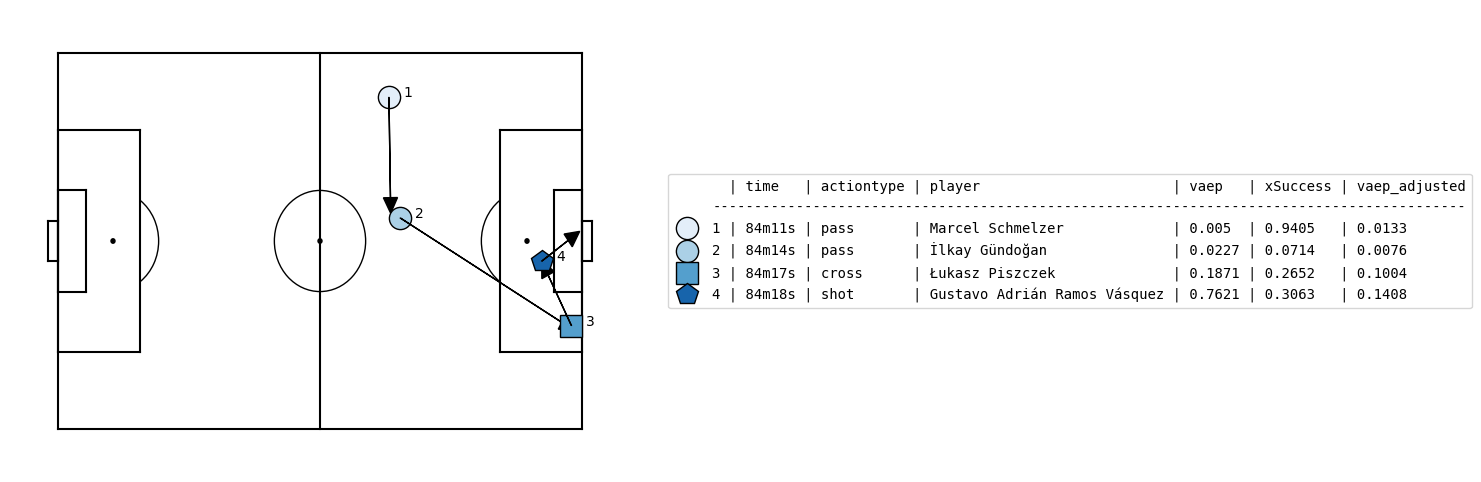

In [88]:
# Select the 5 actions preceding
actions_goal = all_actions_test[(all_actions_test["type_name"] == "shot") & 
                                (all_actions_test["result_name"] == "success") & 
                                (all_actions_test["game_id"] == game_id_1)].sort_values("time_seconds", ascending=True)


shot = actions_goal.index[2]

#a = actions[shot-4:shot+1].copy()
idxs = [shot-4, shot-2, shot-1, shot]
a = all_actions_test.loc[idxs]
a["xSuccess"] = a["xSuccess"].round(4)
a["vaep"] = a["vaep"].round(4)
a["vaep_adjusted"] = a["vaep_adjusted"].round(4)


# Print the game date and timestamp of the goal
g = games[games["game_id"] == game_id_1].iloc[0]

minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "vaep"]].copy()
labels["xSuccess"] = a["xSuccess"].map(lambda v: f"{v:.4f}")
labels["vaep_adjusted"] = a["vaep_adjusted"].map(lambda v: f"{v:.4f}")

fig, ax = plt.subplots(figsize=(8,6))

ax = matplotsoccer.actions(
    ax=ax,
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "vaep" ,"xSuccess", 'vaep_adjusted'],
    zoom=False
)
save_path = os.path.join(subfolder, "actions_plot_1_-_Dortmund_-_Hoffenheim.png")
fig.savefig(save_path, dpi=500, bbox_inches='tight')
plt.show()